In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
from time import time
import matplotlib as pl
import matplotlib.pyplot as plt
import pickle

In [4]:
dataPath = '/Users/omojumiller/mycode/MachineLearningNanoDegree/IntroToMachineLearning/'
sys.path.append(dataPath+'tools/')
sys.path.append(dataPath+'final_project/')

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [5]:
### Load the dictionary containing the dataset

with open(dataPath+'final_project/final_project_dataset.pkl', "r") as data_file:
    data_dict = pickle.load(data_file)

In [7]:
# Remove the source of the outlier
data_dict.pop( 'TOTAL')


{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [20]:
features_list = [ 'long_term_incentive', 'bonus']
data = featureFormat(data_dict, features_list, remove_any_zeroes=True)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

#plt.xticks(np.arange(0, 1e6, 200000), rotation = -60)
plt.xlim((0, 1e7))


plt.xlabel("bonus")
plt.ylabel("long_term_incentive")
plt.show()

In [21]:
def doPCA():
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(data)
    return pca

In [22]:
pca = doPCA()

In [23]:
print pca.explained_variance_ratio_

[ 0.90774318  0.09225682]


In [27]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]

print first_pc, second_pc

[ 0.29782915  0.95461919] [ 0.95461919 -0.29782915]


In [25]:
transformed_data = pca.transform(data)

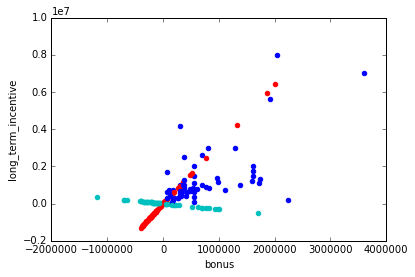

In [30]:
for ii, jj in zip(transformed_data, data):
    plt.scatter( first_pc[0]*ii[0], first_pc[1]*ii[0], color='r' )
    plt.scatter( second_pc[0]*ii[1], second_pc[1]*ii[1], color='c' )
    plt.scatter(jj[0], jj[1], color='b') #original data

#plt.xlim((0, 1e7))
plt.xlabel("bonus")
plt.ylabel("long_term_incentive")
plt.show()

## Eigenfaces

In [31]:
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

Automatically created module for IPython interactive environment


In [32]:
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

In [33]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [34]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [35]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [36]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [37]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [38]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


Extracting the top 150 eigenfaces from 966 faces
done in 0.254s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.026s


In [39]:
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 16.760s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [40]:
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


Predicting the people names on the testing set
done in 0.050s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.76      0.88      0.82        60
  Donald Rumsfeld       0.73      0.70      0.72        27
    George W Bush       0.92      0.87      0.89       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.83      0.83      0.83       322

[[  8   0   3   2   0   0   0]
 [  2  53   1   3   0   1   0]
 [  4   1  19   2   0   0   1]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  20   1   1]
 [  0   2   0   1   2   9   1]
 [  1   1   1   2   1   0  30]]


In [42]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())
        
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)



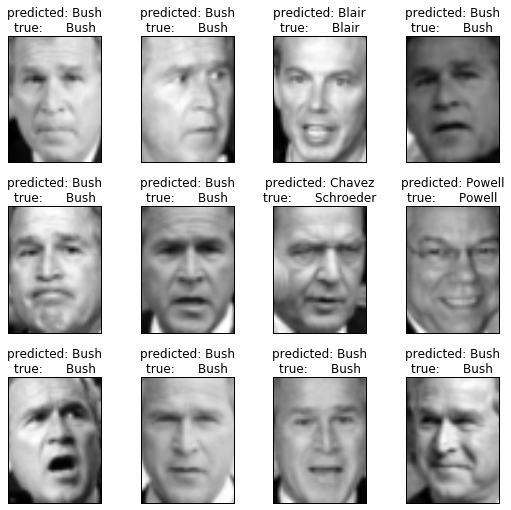

In [43]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


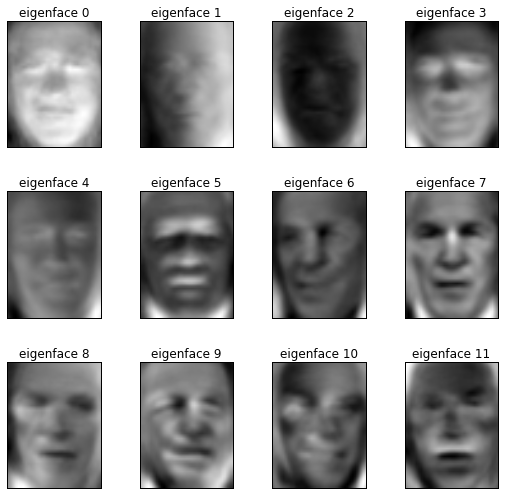

In [44]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()
